In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

ROOT_DIR = os.path.abspath("/Users/jandavidridder/Desktop/Masterarbeit/PYTHON/MYCODE")
PLOT_DIR = os.path.abspath(os.path.join(ROOT_DIR, "..", "..", "plots", "parameter_sampling"))
sys.path.append(ROOT_DIR)
from postprocessing.Visualizer import set_mpt_settings
from scripts.plot import make_colors
set_mpt_settings()
# powerpoint ratio is 14:13
plt.rcParams.update({'font.size': 24})


def _apply_exp_to_lnk(parameters: np.ndarray):
    for i in range(parameters.shape[-1]):
        parameters[..., i] = np.exp(parameters[..., i]) if i % 2 == 0 else parameters[..., i]
    return parameters


latex_notation_map = {
    "k1": r"$k_{0,1}$ / mol kg$_\mathrm{cat}^{-1}$ Pa$^{-1.1}$ s$^{-1}$",
    "k2": r"$k_{0,2}$ / mol kg$_\mathrm{cat}^{-1}$ Pa$^{-1}$ s$^{-1}$",
    "kj": r"$k_{0,j}$ / reaction dependent",
    "EA1": r"$E_{\mathrm{A},1}$ / J mol$^{-1}$",
    "EA2": r"$E_{\mathrm{A},2}$ / J mol$^{-1}$",
    "EAj": r"$E_{\mathrm{A},j}$ / J mol$^{-1}$",
    "lam_bed": r"$\lambda_\mathrm{bed}$ / W m$^{-1}$ K$^{-1}$"
}
light_colors = make_colors(4, alpha=0.3)
full_colors = make_colors(4)

reaction_covariance = np.array(
    [
        [1.75771835e-01, 8.84054955e02, 1.90226410e-01, 9.56652289e02],
        [8.84054955e02, 4.51587249e06, 9.56722528e02, 4.88651035e06],
        [1.90226410e-01, 9.56722528e02, 2.05897698e-01, 1.03542590e03],
        [9.56652289e02, 4.88651035e06, 1.03542590e03, 5.28826120e06],
    ]
)

reaction_mean = np.array([1.56214535e01, 7.48563390e04, 1.62725568e01, 8.98538394e04])
lam_bed_mean = 0.4037066551257339
lam_bed_std = 0.08
true = np.array([6.275e6, 74900, 1.206e7, 89900, lam_bed_mean])
parameters = np.random.multivariate_normal(reaction_mean, reaction_covariance)
lam_bed = np.random.normal(loc=lam_bed_mean, scale=lam_bed_std)
parameters = _apply_exp_to_lnk(parameters)
parameters = np.concatenate([parameters, [lam_bed]])

delta = np.abs(true - parameters)
delta

array([3.08974556e+06, 1.69059412e+03, 6.50737119e+06, 1.82123735e+03,
       5.22476254e-02])

In [2]:
def draw_samples(n: int, cov_factor: float = 1):
    samples = np.zeros((n, 5))
    for i in range(n):
        s = np.random.multivariate_normal(reaction_mean, reaction_covariance*cov_factor)
        samples[i, :4] = _apply_exp_to_lnk(s)
        samples[i, -1] = np.random.normal(lam_bed_mean, lam_bed_std)
    return samples

samples = draw_samples(500, cov_factor=2)

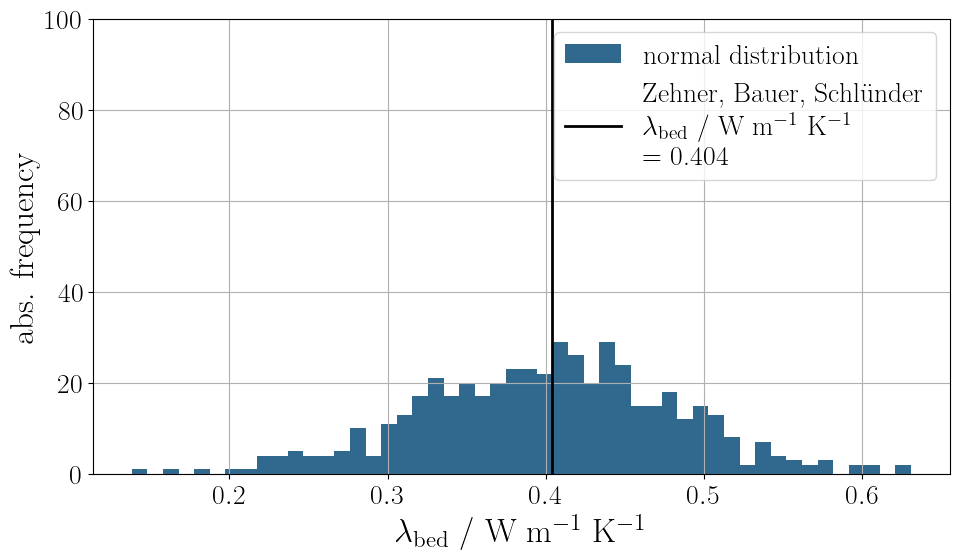

In [3]:
def plot_lambda_histogram(bins=50, fontsize: int = 16):
    plt.rcParams.update({'font.size': fontsize})
    fig, ax = plt.subplots(1, 1)
    ax.hist(samples[:, -1], bins=bins, label="normal distribution", facecolor=full_colors[1])
    label = "Zehner, Bauer, Schlünder \n" + latex_notation_map["lam_bed"] + f" \n = {round(lam_bed_mean, 3)}"
    ax.axvline(x=lam_bed_mean, label=label, color="black")
    ax.set_xlabel(latex_notation_map["lam_bed"])
    ax.set_ylabel("abs. frequency")
    ax.set_ylim(0, 100)
    ax.legend()
    filepath = os.path.join(PLOT_DIR, "lambda_histogram.pdf")
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()
plot_lambda_histogram(fontsize=20)

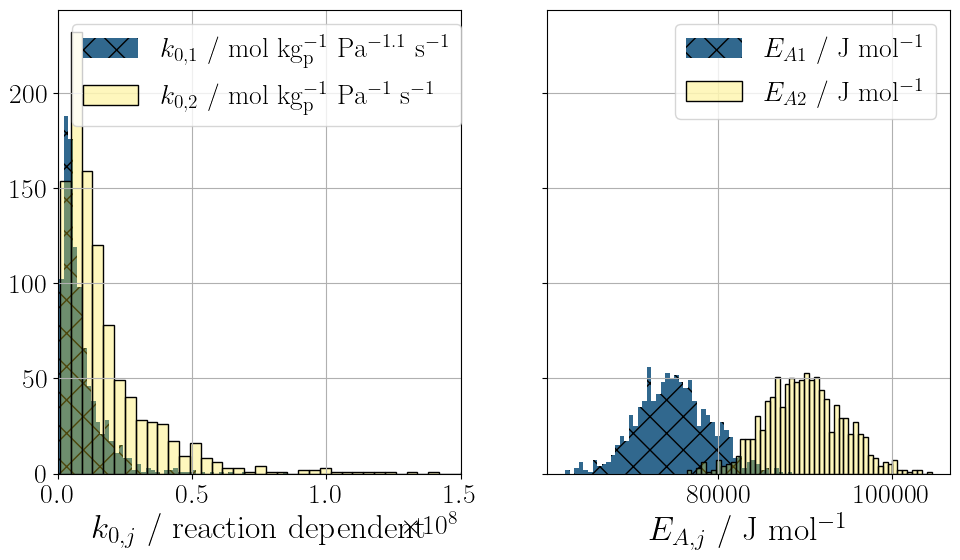

In [7]:
def plot_reaction_histogram(bins=50, fontsize: int = 16):
    plt.rcParams.update({'font.size': fontsize})
    fig, ax = plt.subplots(1, 2, sharey=True)
    ax[0].hist(samples[:, 0], bins=bins, label=latex_notation_map["k1"], hatch="x", facecolor=full_colors[1])
    ax[0].hist(samples[:, 2], bins=bins, label=latex_notation_map["k2"], facecolor=light_colors[3], edgecolor="black")
    ax[0].set_xlabel(latex_notation_map["kj"])
    ax[1].hist(samples[:, 1], bins=bins, label=latex_notation_map["EA1"], hatch="x", facecolor=full_colors[1])
    ax[1].hist(samples[:, 3], bins=bins, label=latex_notation_map["EA2"], facecolor=light_colors[3], edgecolor="black")
    ax[1].set_xlabel(latex_notation_map["EAj"])
    ax[0].set_xlim(0, 1.5e8)
    ax[0].set_ylabel("")

    [a.legend() for a in ax]
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "kinetics_histogram.pdf"))
    plt.show()
plot_reaction_histogram(50, fontsize=20)

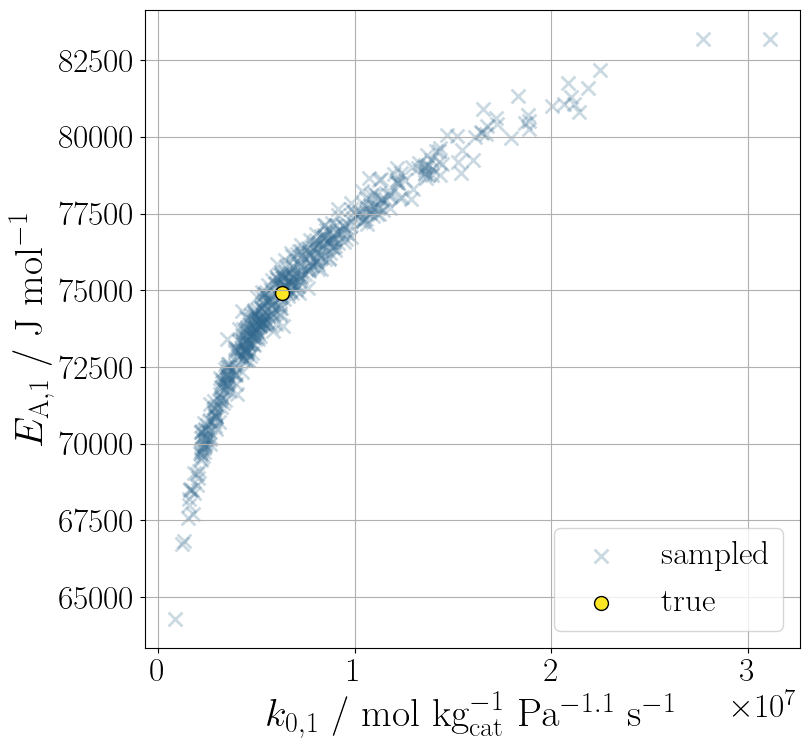

In [35]:
def plot_correlation_k1_EA1():
    color = make_colors(4)[1]
    fig, ax = plt.subplots(1, figsize=(8.615, 8))
    ax.scatter(samples[:, 0], samples[:, 1], label="sampled", marker="x", color=color, alpha=0.25)
    ax.scatter(true[0], true[1], label="true", marker="o", color=make_colors(4)[-1], edgecolor="black")
    ax.set_xlabel(latex_notation_map["k1"])
    ax.set_ylabel(latex_notation_map["EA1"])
    ax.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig(os.path.join(PLOT_DIR, "kinetic_cross_correlation_k1_EA1.svg"))
    plt.show()

plot_correlation_k1_EA1()

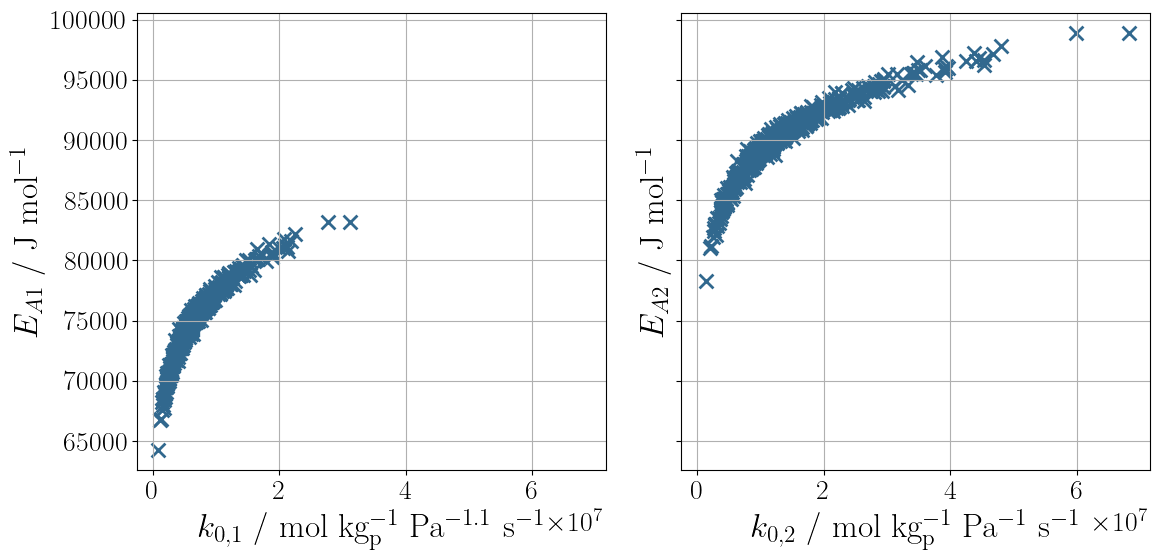

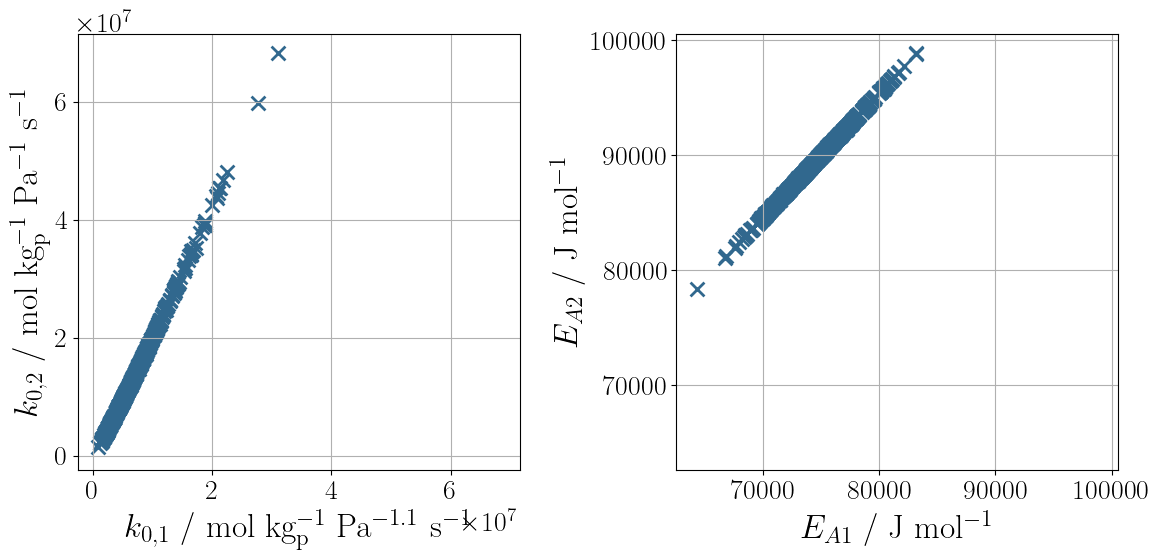

In [4]:
def plot_correlations():
    color = make_colors(4)[1]
    fig1, axes1 = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    axes1[0].scatter(samples[:, 0], samples[:, 1], label="sampled", marker="x", color=color)
    axes1[0].set_xlabel(latex_notation_map["k1"])
    axes1[0].set_ylabel(r"$E_{A1}$ / J mol$^{-1}$")

    axes1[1].scatter(samples[:, 2], samples[:, 3], label="sampled", marker="x", color=color)
    axes1[1].set_xlabel(latex_notation_map["k2"])
    axes1[1].set_ylabel(r"$E_{A2}$ / J mol$^{-1}$")


    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "kinetic_inter_correlation.pdf"))
    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 6))
    axes2[0].scatter(samples[:, 0], samples[:, 2], label="sampled", marker="x", color=color)
    axes2[0].set_xlabel(latex_notation_map["k1"])
    axes2[0].set_ylabel(latex_notation_map["k2"])
    axes2[0].set_xlim(axes1[0].get_xlim())
    axes2[0].set_ylim(axes1[1].get_xlim())

    axes2[1].scatter(samples[:, 1], samples[:, 3], label="sampled", marker="x", color=color)
    axes2[1].set_xlabel(r"$E_{A1}$ / J mol$^{-1}$")
    axes2[1].set_ylabel(r"$E_{A2}$ / J mol$^{-1}$")
    axes2[1].set_xlim(axes1[0].get_ylim())
    axes2[1].set_ylim(axes1[1].get_ylim())

    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "kinetic_cross_correlation.pdf"))
    plt.show()
plot_correlations()